# Implementation of TKAT on USDPEN
### We follow https://github.com/remigenet/TKAT for the USDPEN.

## Installing and importing packages. 

In [2]:
# Basic packages.
!pip3 install pandas numpy matplotlib tensorflow==2.16.1 tkan==0.3.0 tkat==0.1.1 scikit-learn pyarrow

In [3]:
# Basic imports.
# import requests
import time
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten, Input

from tkan import TKAN
from tkat import TKAT

from sklearn.metrics import r2_score

'''
Relevant codes from the peruvian Central Bank.

PD04682MD: Daily interest rate of deposits in PEN, "instantaneous" spot of the yield / ... Multicolinear with tc?
PD04701XD: Daily price for the copper. Exogenous factor.
PD04709XD: EMBIG Spread, country risk indicator. Endogenous factor. Independant?
PD04643PD: USDPEN 11 AM Buy
PD04644PD: USDPEN 11 AM Bid
PD04645PD: USDPEN 01:30 PM Buy
PD04646PD: USDPEN 01:30 PM Bid
'''

'\nRelevant codes from the peruvian Central Bank.\n\nPD04682MD: Daily interest rate of deposits in PEN, "instantaneous" spot of the yield / ... Multicolinear with tc?\nPD04701XD: Daily price for the copper. Exogenous factor.\nPD04709XD: EMBIG Spread, country risk indicator. Endogenous factor. Independant?\nPD04643PD: USDPEN 11 AM Buy\nPD04644PD: USDPEN 11 AM Bid\nPD04645PD: USDPEN 01:30 PM Buy\nPD04646PD: USDPEN 01:30 PM Bid\n'

## Utility Functions.
### MinMax scaler
This scaler makes sure the data we feed the model is normalized between 0 and 1.

In [4]:
# From TKAT MinMaxScaler
class MinMaxScaler:
    def __init__(self, feature_axis=None, minmax_range=(0, 1)):
        """
        Initializating the class
        Args:
        feature_axis (int, optional): The axis that represents the feature dimension if applicable.
                                      Use only for 3D data to specify which axis is the feature axis.
                                      Default is None, automatically managed based on data dimensions.
                                      Usual structure:
                                      [0] = data point
                                      [1] = time
                                      [2] = features
        minmax_range (0, 1):          Range for custom range of transformed values.                         
        """
        self.feature_axis = feature_axis
        self.min_ = None
        self.max_ = None
        self.scale_ = None
        self.minmax_range = minmax_range # 0-1 range by default

    def fit(self, X):
        """
        Fit the scaler to the data based on its dimensionality.
        Args:
        X (np.array): The data to fit the scaler on.
        Returns:
        The scale, mins and maxs of the data provided. Updates the class components.
        """
        if X.ndim == 3 and self.feature_axis is not None:  # 3D data
            axis = tuple(i for i in range(X.ndim) if i != self.feature_axis)
            self.min_ = np.min(X, axis=axis)
            self.max_ = np.max(X, axis=axis)
        elif X.ndim == 2:  # 2D data. Including a feature. 
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        elif X.ndim == 1:  # 1D data, an array of features for one point in history.
            self.min_ = np.min(X)
            self.max_ = np.max(X)
        else:
            raise ValueError("Data must be 1D, 2D, or 3D.")

        self.scale_ = self.max_ - self.min_
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        Args:
        X (np.array): The data to transform.
        Returns:
        np.array: The scaled data, stretched to the custom range.
        """
        X_scaled = (X - self.min_) / self.scale_ # Min = 0, Max = 1.
        X_scaled = X_scaled * (self.minmax_range[1] - self.minmax_range[0]) + self.minmax_range[0]
        return X_scaled

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        Args:
        X (np.array): The data to fit and transform.
        Returns:
        np.array: The scaled data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Inverse transform the scaled data to original data.
        Args:
        X_scaled (np.array): The scaled data to inverse transform.
        Returns:
        np.array: The original scaled data, reverting custom range.
        """
        X = (X_scaled - self.minmax_range[0]) / (self.minmax_range[1] - self.minmax_range[0])
        X = X * self.scale_ + self.min_
        return X

# Building USDPEN data

In [5]:
!pip install alpha_vantage

In [38]:
import datetime as dt
from alpha_vantage.timeseries import TimeSeries

# Initialize the Alpha Vantage API
ts = TimeSeries(key='GUUHGN4HUSL6UGNG')

pairs = [
    "USDPEN",
    "EURPEN",
    "CHFPEN",
    "JPYPEN",
    "AUDPEN",
    "CADPEN",
    "GBPPEN",
    "PENBRX"
]

# Define a consistent column structure
column_names = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'pair']
all_data = []

for pair in pairs:
    try:
        # Fetch daily data
        data, metadata = ts.get_daily(symbol=pair, outputsize='full')
        # Convert to DataFrame
        df = pd.DataFrame.from_dict(data, orient='index')
        df.reset_index(inplace=True)  # Reset index to make timestamp a column
        df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']  # Rename columns
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure the timestamp is datetime
        df['pair'] = pair  # Add currency pair column
        
        # Handle special case for PENBRX
        if pair == "PENBRX":
            df['open'] = 1 / df['open'].astype(float)
            df['high'] = 1 / df['high'].astype(float)
            df['low'] = 1 / df['low'].astype(float)
            df['close'] = 1 / df['close'].astype(float)

        # Append to the list
        all_data.append(df)
        print(f"{pair} done")
    except Exception as e:
        print(f"Error fetching data for {pair}: {e}")

# Combine all DataFrames into one
final_df = pd.concat(all_data, ignore_index=True)

# Ensure column consistency
final_df = final_df[column_names]

# Save to a Parquet file
final_df.to_parquet('currency_pairs2.parquet', engine='pyarrow')
print("Data saved to currency_pairs2.parquet")


USDPEN done
EURPEN done
CHFPEN done
JPYPEN done
AUDPEN done
CADPEN done
GBPPEN done
Error fetching data for PENBRX: Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY.
Data saved to currency_pairs2.parquet


In [6]:
# FIRST RUN.

# Step 1: Load the existing Parquet file
df = pd.read_parquet("currency_pairs2.parquet")

# Step 2: Pivot the DataFrame
# Assuming the columns are ['timestamp', 'pair', 'open', 'high', 'low', 'close', 'volume']
pivoted_df = df.pivot(index='timestamp', columns='pair', values=['open', 'high', 'low', 'close', 'volume'])

# Step 3: Flatten the MultiIndex in columns
pivoted_df.columns = ['_'.join(col).strip() for col in pivoted_df.columns.values]
pivoted_df.reset_index(inplace=True)

# Step 4: Save the pivoted DataFrame to a new Parquet file
pivoted_df.to_parquet("pivoted_currency_pairs.parquet", engine="pyarrow")

print("Pivoted data saved to pivoted_currency_pairs.parquet")


Pivoted data saved to pivoted_currency_pairs.parquet


In [3]:
# Read the Parquet file
df = pd.read_parquet('currency_pairs2.parquet', engine='pyarrow')  # or engine='fastparquet'

# Display the DataFrame
print(df)

       timestamp    open    high     low   close volume    pair
0     2024-11-15  3.8022  3.8042  3.8020  3.8042      0  USDPEN
1     2024-11-14  3.8005  3.8040  3.8004  3.8022      0  USDPEN
2     2024-11-13  3.7858  3.8017  3.7858  3.8005      0  USDPEN
3     2024-11-12  3.7747  3.7900  3.7746  3.7860      0  USDPEN
4     2024-11-11  3.7686  3.7747  3.7686  3.7747      0  USDPEN
...          ...     ...     ...     ...     ...    ...     ...
18261 2014-11-13  4.6302  4.6328  4.6103  4.6121      0  GBPPEN
18262 2014-11-12  4.6631  4.6659  4.6288  4.6296      0  GBPPEN
18263 2014-11-11  4.6504  4.6708  4.6504  4.6641      0  GBPPEN
18264 2014-11-10  4.6514  4.6594  4.6398  4.6411      0  GBPPEN
18265 2014-11-07  4.6423  4.6510  4.6419  4.6482      0  GBPPEN

[18266 rows x 7 columns]


In [4]:
# Read the Parquet file
df2 = pd.read_parquet('pivoted_currency_pairs.parquet', engine='pyarrow')  # or engine='fastparquet'

# Display the DataFrame
print(df2)

      timestamp open_AUDPEN open_CADPEN open_CHFPEN open_EURPEN open_GBPPEN  \
0    2014-11-07      2.5188      2.5771      3.0223      3.6370      4.6423   
1    2014-11-10      2.5270      2.5811      3.0342      3.6500      4.6514   
2    2014-11-11      2.5322      2.5796      3.0260      3.6410      4.6504   
3    2014-11-12      2.5420      2.5794      3.0366      3.6540      4.6631   
4    2014-11-13      2.5535      2.5895      3.0351      3.6500      4.6302   
...         ...         ...         ...         ...         ...         ...   
2605 2024-11-11      2.4799      2.7045      4.3023      4.0420      4.8703   
2606 2024-11-12      2.4780      2.7076      4.2872      4.0241      4.8596   
2607 2024-11-13      2.4670      2.7092      4.2875      4.0193      4.8260   
2608 2024-11-14      2.4637      2.7126      4.2916      4.0158      4.8312   
2609 2024-11-15      2.4556      2.7009      4.2765      4.0098      4.8226   

     open_JPYPEN open_USDPEN high_AUDPEN high_CADPE

In [28]:
# Keeping only closing prices.

df = pd.read_parquet('pivoted_currency_pairs.parquet')
assets = ["USDPEN",
    "EURPEN",
    "CHFPEN",
    "JPYPEN",
    "AUDPEN",
    "CADPEN",
    "GBPPEN",
    "timestamp"]

df = df.reset_index()
df = df[['timestamp'] + [c for c in df.columns if 'close' in c and any(asset in c for asset in assets)]]
df = df.set_index('timestamp')
display(df)

,close_AUDPEN,close_CADPEN,close_CHFPEN,close_EURPEN,close_GBPPEN,close_JPYPEN,close_USDPEN
timestamp,,,,,,,
2014-11-07,2.5240,2.5807,3.0292,3.6470,4.6482,0.0251,2.9270
2014-11-10,2.5211,2.5700,3.0248,3.6380,4.6411,0.0250,2.9270
2014-11-11,2.5423,2.5787,3.0368,3.6540,4.6641,0.0248,2.9280
2014-11-12,2.5544,2.5894,3.0364,3.6500,4.6296,0.0249,2.9350
2014-11-13,2.5530,2.5773,3.0466,3.6630,4.6121,0.0249,2.9345
...,...,...,...,...,...,...,...
2024-11-11,2.4783,2.7076,4.2864,4.0238,4.8598,0.0241,3.7747
2024-11-12,2.4716,2.7125,4.2952,4.0240,4.8289,0.0240,3.7860
2024-11-13,2.4614,2.7115,4.2898,4.0159,4.8321,0.0239,3.8005


In [29]:
# Formatting database as in the example.
df.columns = [c.replace('close_', '') for c in df.columns]
df = df.apply(pd.to_numeric, errors='coerce')

# Creating seasonal data.
known_input_df = pd.DataFrame(index=df.index, data=np.array([df.reset_index()['timestamp'].apply(lambda x: (x.hour)).values, df.reset_index()['timestamp'].apply(lambda x: (x.dayofweek)).values]).T, columns = ['hour', 'dayofweek'])

# Dropping hours as the database is daily for now.
known_input_df = known_input_df.drop(columns=['hour'])

display(df)
display(known_input_df)

,AUDPEN,CADPEN,CHFPEN,EURPEN,GBPPEN,JPYPEN,USDPEN
timestamp,,,,,,,
2014-11-07,2.5240,2.5807,3.0292,3.6470,4.6482,0.0251,2.9270
2014-11-10,2.5211,2.5700,3.0248,3.6380,4.6411,0.0250,2.9270
2014-11-11,2.5423,2.5787,3.0368,3.6540,4.6641,0.0248,2.9280
2014-11-12,2.5544,2.5894,3.0364,3.6500,4.6296,0.0249,2.9350
2014-11-13,2.5530,2.5773,3.0466,3.6630,4.6121,0.0249,2.9345
...,...,...,...,...,...,...,...
2024-11-11,2.4783,2.7076,4.2864,4.0238,4.8598,0.0241,3.7747
2024-11-12,2.4716,2.7125,4.2952,4.0240,4.8289,0.0240,3.7860
2024-11-13,2.4614,2.7115,4.2898,4.0159,4.8321,0.0239,3.8005


,dayofweek
timestamp,
2014-11-07,4
2014-11-10,0
2014-11-11,1
2014-11-12,2
2014-11-13,3
...,...
2024-11-11,0
2024-11-12,1
2024-11-13,2


In [13]:
known_input_df = pd.DataFrame(index=df.index, data=np.array([df.reset_index()['timestamp'].apply(lambda x: (x.hour)).values, df.reset_index()['timestamp'].apply(lambda x: (x.dayofweek)).values]).T, columns = ['hour', 'dayofweek'])

# Dropping hours for now.
known_input_df = known_input_df.drop(columns=['hour'])

display(known_input_df)

,dayofweek
0,4
1,3
2,2
3,1
4,0
...,...
18261,3
18262,2
18263,1
18264,0


In [30]:
N_MAX_EPOCHS = 100
BATCH_SIZE = 128
early_stopping_callback = lambda : tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=6,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=6,
)
lr_callback = lambda : tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    mode="min",
    min_delta=0.00001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), tf.keras.callbacks.TerminateOnNaN()]

In [31]:
def generate_data(df, sequence_length, n_ahead):
    #Case without known inputs
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    def prepare_sequences(df, scaler_df, n_history, n_future):
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

def generate_data_w_known_inputs(df, known_input_df, sequence_length, n_ahead):
    #Case without known inputs - fill with 0 the unknown features future values in X
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    tmp_known_input_df = known_input_df.iloc[24 * 14 + n_ahead:].copy()
    def prepare_sequences(df, known_input_df, scaler_df, n_history, n_future):
        Xu, Xk, y, y_scaler = [], [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            Xu.append(np.concatenate((df.iloc[i - n_history:i].values, np.zeros((n_future, df.shape[1]))), axis=0))
            Xk.append(known_input_df.iloc[i - n_history:i+n_future].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        Xu, Xk, y, y_scaler = np.array(Xu), np.array(Xk), np.array(y), np.array(y_scaler)
        return Xu, Xk, y, y_scaler
    
    # Prepare sequences
    Xu, Xk, y, y_scaler = prepare_sequences(tmp_df, tmp_known_input_df, scaler_df, sequence_length, n_ahead)

    X = np.concatenate((Xu, Xk), axis=-1)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

In [36]:
num_hidden = 100
num_heads = 4
num_embedding = 1
n_ahead = 30
sequence_length = 5 * n_ahead

X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data_w_known_inputs(df, known_input_df, sequence_length, n_ahead)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1652, 180, 8), (413, 180, 8), (1652, 30), (413, 30))

In [37]:
num_unknow_features = len(assets)
num_know_features = X_train.shape[2] - num_unknow_features

model = TKAT(sequence_length, num_unknow_features, num_know_features, num_embedding, num_hidden, num_heads, n_ahead, use_tkan = True)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)

preds = model.predict(X_test).flatten()
errors = preds - y_test.flatten()
rmse = np.sqrt(np.mean(np.square(errors)))
r2 = r2_score(y_true=y_test.flatten(), y_pred=preds)
mae = np.mean(np.abs(errors))

metrics_summary = f"""
Model Type: TKAT
------------------------------------
Root Mean Squared Error (RMSE): {rmse:.4f}
R-squared (R²) Score: {r2:.4f}
Mean Absolute Error (MAE): {mae:.4f}
"""
print(metrics_summary)

all_errors = {}
preds = model.predict(X_test)
errors = preds-y_test
all_errors['TKAT'] = errors

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 180, 1, 8) │          0 │ input_layer[0][0] │
│ (EmbeddingLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ past_observed_and_… │ (None, 150, 1, 8) │          0 │ embedding_layer[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_past_features   │ (None, 150, 100)  │    259,904 │ past_observed_an… │
│ (VariableSelection… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_known        │ (None, 30, 1, 8)  │          0 │ embedding_layer[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 150,      │     71,612 │ vsn_past_feature… │
│ (RecurrentLayer)    │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_future_features │ (None, 30, 100)   │    259,904 │ future_known[0][… │
│ (VariableSelection… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 30, 100)   │     71,612 │ vsn_future_featu… │
│ (RecurrentLayer)    │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2],    │
│                     │                   │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 180, 100)  │          0 │ encoder[0][0],    │
│ (Concatenate)       │                   │            │ decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate_18 (Gate)      │ (None, 180, 100)  │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 180, 100)  │          0 │ vsn_past_feature… │
│ (Concatenate)       │                   │            │ vsn_future_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_and_norm_18     │ (None, 180, 100)  │        200 │ gate_18[0][0],    │
│ (AddAndNorm)        │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_18 (GRN)        │ (None, 180, 100)  │          0 │ add_and_norm_18[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 100)  │    161,300 │ grn_18[0][0],     │
│ (MultiHeadAttentio… │                   │            │ grn_18[0][0],     │
│                     │                   │            │ grn_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18000)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 30)        │    540,030 │ flatten[0][0]   

 Total params: 1,364,562 (5.21 MB)

 Trainable params: 1,364,542 (5.21 MB)

 Non-trainable params: 20 (80.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step

Model Type: TKAT
------------------------------------
Root Mean Squared Error (RMSE): 0.1667
R-squared (R²) Score: -1.3777
Mean Absolute Error (MAE): 0.1381

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step


In [38]:
models = ['TKAN', 'MLP', 'GRU', 'LSTM']


for model_type in models:
    
    X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)

    if 'TKAN' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            TKAN(100, tkan_activations=[{'grid_size': 3} for i in range(5)], sub_kan_output_dim = 20, sub_kan_input_dim = 1, return_sequences=True),
            TKAN(100, tkan_activations=[{'grid_size': 3} for i in range(5)], sub_kan_output_dim = 20, sub_kan_input_dim = 1, return_sequences=False),
            Dense(units=n_ahead, activation='linear')
        ])
    elif 'GRU' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            GRU(100, return_sequences=True),
            GRU(100, return_sequences=False),
            Dense(units=n_ahead, activation='linear')
        ])
    elif 'LSTM' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            LSTM(100, return_sequences=True),
            LSTM(100, return_sequences=False),
            Dense(units=n_ahead, activation='linear')
        ])
    elif 'MLP' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            Flatten(),
            Dense(100, activation='relu'),
            Dense(100, activation='relu'),
            Dense(units=n_ahead, activation='linear')
        ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.summary()

    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)
    preds = model.predict(X_test)
    errors = preds-y_test
    all_errors[model_type] = errors

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_2 (TKAN)                   │ (None, 150, 100)       │        43,685 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_3 (TKAN)                   │ (None, 100)            │        72,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,765 (463.93 KB)

 Trainable params: 118,665 (463.54 KB)

 Non-trainable params: 100 (400.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1050)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 100)            │       105,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,230 (461.84 KB)

 Trainable params: 118,230 (461.84 KB)

 Non-trainable params: 0 (0.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 150, 100)       │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,330 (376.29 KB)

 Trainable params: 96,330 (376.29 KB)

 Non-trainable params: 0 (0.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 100)       │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,630 (494.65 KB)

 Trainable params: 126,630 (494.65 KB)

 Non-trainable params: 0 (0.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


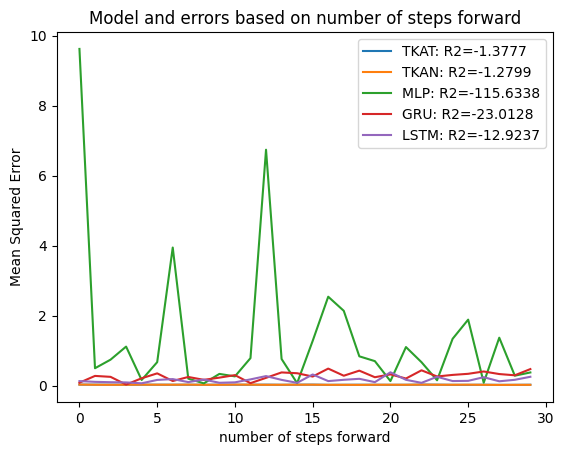

In [40]:
model_types = ['TKAT', 'TKAN', 'MLP', 'GRU', 'LSTM']
grey_shades = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Darker to lighter

for model_type, color in zip(model_types, grey_shades):
    y_pred = all_errors[model_type] + y_test
    r2 = r2_score(y_true=y_test.flatten(), y_pred=y_pred.flatten())
    plt.plot(np.mean(all_errors[model_type]**2, axis=0), label=f'{model_type}: R2={round(r2,4)}', color=color)

plt.legend()
plt.title('Model and errors based on number of steps forward')
plt.xlabel('number of steps forward')
plt.ylabel('Mean Squared Error')
plt.show()